# Week 4: Intro to Differential Expression Analysis 🧬

From a biological standpoint, it's understood that differential expression analysis explores the differences in gene expression between two separate groups. This can be achieved through performing bulk RNA sequencing (bulk RNA-seq) on various sample of interest and corresponding controls. A review of the protocol for bulk RNA-seq, from one the original papers which used this method, can be found through the following link https://pubmed.ncbi.nlm.nih.gov/18516045/ and extended reading on RNA-seq data processing can be found at https://statomics.github.io/SGA/sequencing_intro.html.

![workflow.jpg](https://drive.google.com/uc?export=view&id=1B1SnsccJahXAPf7uZf7lcpI8nCEwedEq)

In this module, we will shift our view to the computational examination of bulk RNA-Seq data. We'll delve into utilizing Python-based tools for this analysis, understanding the function parameters, and deciphering the outcomes.

By the end of this module, you will be equipped to accomplish the following tasks:

- Apply necessary preprocessing steps to the tabular data
- Perform exploratory data analysis to look at data quality
- Run the differential expression analysis
- Interpret the results of the identified differentially expressed genes (DEGs)

Next module, we will expand upon your findings and progress to visualizations and subsequent in-depth analysis, an essential phase in the data analysis workflow. Visualization aids in a more intuitive grasp of the data and can reveal trends or insights that raw data may not readily show. Engaging in further downstream analysis will enable you to formulate more definitive conclusions, evaluate hypotheses, or develop predictive models grounded in your preliminary results.


##Introduction

The complexity of gene expression data requires sophisticated statistical software to accurately identify DEGs. These tools must be able to handle large datasets, correct for multiple testing, and account for variability within and between sample groups. Traditionally, this sort of analysis would be done in R, not for any major reason other than that varying organizations have already developed infrastructure for R that may support differential expression analysis. However, slowly but surely the models and algorithms are being transcribed to Python.

We will focus on a Python package called `pyDESeq2`, a Python implementation of the popular R package known as `DESeq2`. This external package will do most of the heavy lifting for us, we just have to supply it with the correctly formatted data. You can find the original paper that presented `DESeq2` with the following link https://pubmed.ncbi.nlm.nih.gov/25516281/

### Dataset

We will examine a dataset that contains gene expression data from the smooth muscle tissue of the airways in asthma patients. This dataset includes two groups: a treatment group that has received the asthma medication dexamethasone, and a control group of asthma patients who have not received any medication. The dataset comprises a total of eight samples, with four samples per group. For the purposes of this lesson, we have pre-processed the extensive raw RNA-Seq data files by aligning, verifying, and quantifying them. This preprocessing leaves us with a table of raw transcript counts. In this module, you will be exploring a specific file "airway_rawcounts.csv" which possess the **count matrix**, a table listing the raw transcript counts for each gene in each sample. Let's begin by loading in and viewing this count matrix.

You can view and download the dataset from [airway_rawcounts.csv](https://drive.google.com/file/d/1YpPVt8tdOA4CCZhyJAPfoHKemL4RjXQM/view?usp=drive_link)

In [ ]:
import pandas as pd

counts = pd.read_csv("airway_rawcounts.csv")

counts

,ensgene,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
0,ENSG00000000003,679,448,873,408,1138,1047,770,572
1,ENSG00000000005,0,0,0,0,0,0,0,0
2,ENSG00000000419,467,515,621,365,587,799,417,508
3,ENSG00000000457,260,211,263,164,245,331,233,229
4,ENSG00000000460,60,55,40,35,78,63,76,60
...,...,...,...,...,...,...,...,...,...
63672,ENSG00000273489,0,0,0,1,0,1,0,0
63673,ENSG00000273490,0,0,0,0,0,0,0,0
63674,ENSG00000273491,0,0,0,0,0,0,0,0
63675,ENSG00000273492,0,0,1,0,0,0,0,0


**Q1. By using multiple samples, we are comparing the distributions of the transcript abundance for one gene between two groups. What sort of statistical test can you relate this to?**

**You may find commonly-used statistical tests here: https://medium.com/@anushka.da3/types-of-statistical-tests-b8ceb90e13b3**

**Write Answer Below**

- t-test
- Mann-Whitney U test
- ANOVA

Any of the above would be valid answers, as well as any other stastical test of distributions.

## Data Preprocessing

Our `counts` DataFrame has the samples as the columns and the genes as the rows. In our analysis, it's essential to focus on data that can give us meaningful insights. This means we can exclude any gene that hasn't shown activity across all of our samples. To refine our `counts` DataFrame, we'll perform a simple but effective data cleaning step.

Here's how we'll do it:

1. **Assign the row names of the DataFrame to the first column**: We will change the rownames to be the first column for formatting puposes. There is no need for the row columns to be just arbitrary numbers specifying the gene's position in the DataFrame.

In [ ]:
# Setting rownames to Geneid
counts = counts.set_index('ensgene')

2. **Calculating the sum of counts per gene**: We'll sum up the counts across all columns for each gene. This is done to identify genes that show no expression at all in any of the samples. Here, the parameter, **axis** specifies how we want to sum our samples. Setting it to 1 means that we would like the sum of each row.

In [ ]:
# Calculate the sum of counts for each gene across all samples
row_sums = counts.sum(axis=1)

3. **Removing non-informative data our DataFrame**: We'll modify the `counts` DataFrame to keep only the rows (genes) that have a sum of counts greater than zero.

In [ ]:
# Filter the DataFrame to retain only rows with nonzero total counts
counts = counts[row_sums > 0]

We can relate the samples as the observations, and the genes as the variables/features of our dataset. Thus, it would be conventional to swap the columns and rows so that the samples are the rows while the variables are the columns. Moreover, when passing this table to pyDESeq2, it is assumed that the samples are the rows.

In [ ]:
# Transpose counts table
counts = counts.T

counts

ensgene,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,...,ENSG00000273477,ENSG00000273478,ENSG00000273483,ENSG00000273485,ENSG00000273486,ENSG00000273487,ENSG00000273488,ENSG00000273489,ENSG00000273492,ENSG00000273493
SRR1039508,679,467,260,60,0,3251,1433,519,394,172,...,4,9,5,2,14,5,7,0,0,0
SRR1039509,448,515,211,55,0,3679,1062,380,236,168,...,9,8,2,3,11,9,5,0,0,0
SRR1039512,873,621,263,40,2,6177,1733,595,464,264,...,6,7,0,1,25,4,8,0,1,0
SRR1039513,408,365,164,35,0,4252,881,493,175,118,...,2,5,2,1,8,11,3,1,0,0
SRR1039516,1138,587,245,78,1,6721,1424,820,658,241,...,8,6,3,1,20,10,8,0,0,1
SRR1039517,1047,799,331,63,0,11027,1439,714,584,210,...,9,8,2,1,32,10,16,1,0,0
SRR1039520,770,417,233,76,0,5176,1359,696,360,155,...,6,5,1,1,12,4,11,0,0,0
SRR1039521,572,508,229,60,0,7995,1109,704,269,177,...,12,6,6,0,11,10,14,0,0,0


To perform a detailed differential expression analysis, it's essential to consider the experiment's context, including each sample's collection conditions. This context is known as metadata, or "sample information" in DESeq2, referred to as `colData`.

The count matrix holds the gene expression data but lacks the experimental condition descriptions for each sample, crucial for the analysis. To remedy this, we need to create a metadata DataFrame labeling each sample's condition as "treatment" (`T`) or "control" (`C`).

We'll match each sample to its condition in the metadata DataFrame, ensuring it aligns with the count matrix's sample order. This involves making a concise pandas DataFrame with one column, where labels correspond to the count matrix's sample order, facilitating accurate data analysis.

In [ ]:
# Create a DataFrame with sample conditions, using the index from the count matrix
metadata = pd.DataFrame({
    'Condition': ['C', 'T', 'C', 'T', 'C', 'T', 'C', 'T']}, index=counts.index)
metadata

,Condition
SRR1039508,C
SRR1039509,T
SRR1039512,C
SRR1039513,T
SRR1039516,C
SRR1039517,T
SRR1039520,C
SRR1039521,T


Let us see what happens when we do not set up the metadata of the count matrix correctly.

Run the code below. You may notice that there is an extra `T` at the end of the list.

The error involves the fact that there is a mismatch between the `Condition` list and the number of samples in the count matrix. The line of code knows how many samples there are in the count matrix for it is included when we specified the index parameter.

In [ ]:
# Create a DataFrame with sample conditions, using the index from the count matrix
test_metadata = pd.DataFrame({
    'Condition': ['C', 'T', 'C', 'T', 'C', 'T', 'C', 'T', 'T']}, index = counts.index)
test_metadata

ValueError: Length of values (9) does not match length of index (8)

## Exploratory Data Analysis

In this section, we learn how we do hypothesis testing and differential gene expression analysis of RNA-seq data using pyDESeq

Now we have set up our data to be used by pyDESeq, but before we run our extensive analysis, it's first a good idea to get some preliminary analytics as to how well our groups may be distinguished from each other. There are many ways to do this, but one common was is to use principle component analysis (PCA), which you have learned in the last module.

PCA is a common pick because we are working with data utilizing genes as feature; thus, our data is of high dimensionality. Moreover, We would like to be able to see a visualization as to how well the data clusters into the two groups; thus, we need to reduce the number of features to 2 (or 3 as a 3D plot is possible as well).

The PCA results helps us visualize the clustering of samples based on their gene expression profiles. This is useful in identifying groups of samples that are similar to each other, which might indicate similar biological conditions, treatment groups, or technical batches.

Below is the implementation of a PCA plot labelled using the condition of the sample. We are hoping to see that the two groups cluster well and there is minimal overlap.

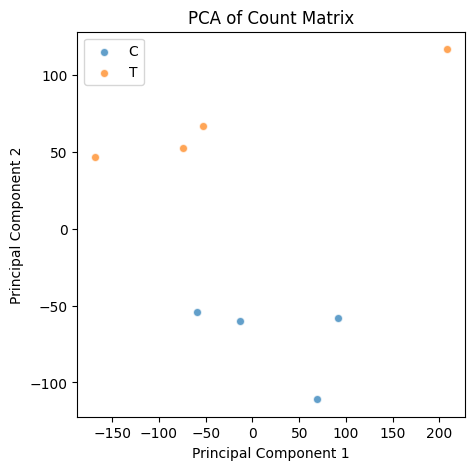

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Standardize the count matrix
scaler = StandardScaler()
scaled_counts = scaler.fit_transform(counts)

# Step 2: Compute PCA
pca = PCA(n_components=2)  # Choosing 2 components for a 2D plot
pca_result = pca.fit_transform(scaled_counts)

# Step 3: Prepare the data for plotting
# Convert the PCA results into a DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=counts.index)

# Join the PCA results with the metadata to align the samples with their labels
plot_data = pca_df.join(metadata)

# Step 4: Plot the PCA
plt.figure(figsize=(5, 5))
for condition in plot_data['Condition'].unique():
    # Select data points belonging to the current condition
    subset = plot_data[plot_data['Condition'] == condition]
    plt.scatter(subset['PC1'], subset['PC2'], label=condition, alpha=0.7, edgecolors='w')

plt.title('PCA of Count Matrix')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


**Q3: Does Principal Component 1 or Principal Component 2 explain the separation between the data points of treatment and control groups better? Explain your reasoning.**

**Write Answer Below**

example answer: PC2 accounts for more of the variance between the treatment and control groups than PC1 because we can draw a clear line between the groups along the y axis but not the x axis.


## Differential Expression Analysis

To practically implement differential expression analysis using PyDESeq2, we begin by constructing a DESeqDataSet object, commonly referred to as `dds` in code examples. This object is central to the PyDESeq2 workflow as it encapsulates all the data required for the analysis, including the count data and the associated sample metadata.

The creation of the `dds` object is not just a formality but a critical step that ensures data integrity and prepares the dataset for the subsequent analysis stages. It checks for consistency between the count data and the metadata, and it sets the stage for incorporating the experimental design into the analysis.

Here's how we create the DESeqDataSet object in practice:

1. **Prepare the count data and metadata**: Ensure that your count matrix and metadata DataFrame are correctly formatted and aligned.

2. **Define the experimental design**: Specify the design of your experiment by indicating which column in the metadata DataFrame represents the condition or factor of interest.

3. **Create the DESeqDataSet object**: Use the count data and metadata to initialize the DESeqDataSet object, incorporating the experimental design.

The Python code to create the "dds" object looks like what's below, but enter the corresponding variables for the count matrix and metadata table that we have prepared:

**Q4: We left out the parameter values for you. Please adjust the code to correctly use the input data as parameters.**

In [ ]:
!pip install pydeseq2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 4.5 MB/s eta 0:00:00


In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# TODO: Enter counts and metadata parameters
dds = DeseqDataSet(counts = counts, metadata = metadata, design_factors = 'Condition')

Below we will finally run the differential expression analysis and compare the distributions of each gene. To acheive this, we simply call the `deseq2` function. It carries out several steps to determine which genes or transcripts are differentially expressed across your conditions of interest:

- **Normalization**: DESeq2 employs data adjustment techniques to ensure a fair comparison of gene expression between samples, similar to ensuring that two fruit baskets being compared are of the same size. This normalization process in DESeq2 is performed to remove biases stemming from differences in sequencing depths or other technical factors, making it possible to accurately assess gene expression changes across samples.

- **Variability Estimation**: It calculates how much the expression of each gene varies naturally, so we can distinguish real differences from random noise. This is based on the variability observed across all samples within the experimental conditions or groups being compared. In fact, DESeq2 requires at least 2 replicates per group for the analysis (as a bare minimum; at least 3 however, is usually recommended).

- **Testing for Differences**: DESeq2 then identifies genes that are consistently expressed differently between conditions, beyond what would be expected by chance.

- **Results**: It provides a list of these genes, along with the strength and certainty of their differential expression.

In [ ]:
dds.deseq2()

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 37.22 seconds.

Fitting dispersion trend curve...
... done in 1.11 seconds.

Fitting MAP dispersions...
... done in 65.27 seconds.

Fitting LFCs...
... done in 31.17 seconds.

Calculating cook's distance...
... done in 0.08 seconds.

Replacing 0 outlier genes.



After you run the analysis with DESeq2, your data object gets updated with new information. This includes adjustments made to account for different amounts of data across samples, measurements of variability for each gene, and the estimated changes in gene expression. While the detailed results aren't stored directly in this object, it does hold key figures and notes about the analysis that can be useful for further examination and interpretation.

To obtain the results of the differential expression tests we must construct a `DeseqStats` object using our `DESeqDataSet` object. In this object, we must specify which 2 groups we are comparing based on our metadata. As you can expect, we are comparing based on "Condition", the column name in the metadata table. We are specifically comparing between `T`, samples treated with dexmethasone, and `C`, control samples. Finally, by calling summary, it runs the statistical analysis and generates us a comprehensive table with our statistical results.

From these statistical results, you may already be able to draw biological interpretations and conclusions, Thus, it would be most beneficial to get familiar with what each of these columns represent:

| Term             | Description |
|------------------|-------------|
| `baseMean`       | The average of the normalized counts for a gene across all samples and conditions. |
| `log2FoldChange` | The log (base 2) of the fold change between conditions. Positive values indicate up-regulation, and negative values indicate down-regulation. |
| `lfcSE`          | The standard error of the log2 fold change, indicating the uncertainty of the `log2FoldChange` estimate. |
| `stat`           | The Wald test statistic used to test the significance of the `log2FoldChange`. |
| `pvalue`         | The p-value from the Wald test, showing the probability of observing the data if there was no true difference in expression. |
| `padj`           | The adjusted p-value accounting for multiple testing, reducing the chance of false positives in significant gene identification. |

The `pvalue` measures the chance of observing gene expression differences if no actual difference exists, identifying significant changes. However, with multiple tests, false positives increase. The `padj` corrects for this by adjusting p-values for multiple comparisons, using methods like Bonferroni, Benjamini-Hochberg, and FDR to control the overall error rate, typically set at 0.05.

Fold changes show gene expression differences between conditions, with their significance depending on the analysis order. For "Condition T vs C," a positive fold change means treatment (T) has more transcripts than control (C), emphasizing the importance of condition order in result interpretation.

In [ ]:
# Calculate the statistical results
res = DeseqStats(dds, contrast=('Condition', 'T', 'C'))
res.summary()

Running Wald tests...
... done in 8.34 seconds.



Log2 fold change & Wald test p-value: Condition T vs C
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ensgene                                                                     
ENSG00000000003  708.602170       -0.378860  0.173829 -2.179501  0.029294   
ENSG00000000419  520.297901        0.203748  0.099570  2.046276  0.040729   
ENSG00000000457  237.163037        0.034101  0.124390  0.274146  0.783973   
ENSG00000000460   57.932633       -0.117126  0.296504 -0.395022  0.692826   
ENSG00000000938    0.318098       -1.726440  3.586871 -0.481322  0.630288   
...                     ...             ...       ...       ...       ...   
ENSG00000273487    8.163235        1.014039  0.556511  1.822137  0.068434   
ENSG00000273488    8.584479        0.221732  0.550367  0.402880  0.687037   
ENSG00000273489    0.275899        1.546042  3.724653  0.415084  0.678081   
ENSG00000273492    0.105978       -0.540731  3.871056 -0.139686  0.888908   
ENSG00000273493    0.

Now, we would like this table above as specifically a pandas dataframe, so we could make adjustments to it such as futher filtering. We will save this new dataframe as `res_df`.

In [ ]:
# Extracting the results dataframe
res_df = res.results_df
res_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ensgene,,,,,,
ENSG00000000003,708.602170,-0.378860,0.173829,-2.179501,0.029294,0.143413
ENSG00000000419,520.297901,0.203748,0.099570,2.046276,0.040729,0.178607
ENSG00000000457,237.163037,0.034101,0.124390,0.274146,0.783973,0.929945
ENSG00000000460,57.932633,-0.117126,0.296504,-0.395022,0.692826,0.893503
ENSG00000000938,0.318098,-1.726440,3.586871,-0.481322,0.630288,NaN
...,...,...,...,...,...,...
ENSG00000273487,8.163235,1.014039,0.556511,1.822137,0.068434,0.254193
ENSG00000273488,8.584479,0.221732,0.550367,0.402880,0.687037,0.890211
ENSG00000273489,0.275899,1.546042,3.724653,0.415084,0.678081,NaN


You may have noticed that these genes are labeled with their **Ensembl IDs**. Although this naming scheme is very structured and orderly, it is very hard for an individual to decipher and identify genes of interest, akin to trying to identify a product at a grocery store by reading its barcode instead of reading the label. Therefore, we will map these Ensembl IDs to their Gene Symbol counterparts through the use of a dictionary obtained from an external library that we import. In the results dataframe, we will add a new column that consists of these gene names.

In [ ]:
!pip install sanbomics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.6 MB/s eta 0:00:00


In [ ]:
# Package to help perform downstream analysis
from sanbomics.tools import id_map

# Obtaining the dictionary mapping ensembl ids to Gene symbols
human_mapper = id_map(species = 'human')

# Adding a column of the gene names.
res_df['Symbol'] = res_df.index.map(human_mapper.mapper)
res_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
ensgene,,,,,,,
ENSG00000000003,708.602170,-0.378860,0.173829,-2.179501,0.029294,0.143413,TSPAN6
ENSG00000000419,520.297901,0.203748,0.099570,2.046276,0.040729,0.178607,DPM1
ENSG00000000457,237.163037,0.034101,0.124390,0.274146,0.783973,0.929945,SCYL3
ENSG00000000460,57.932633,-0.117126,0.296504,-0.395022,0.692826,0.893503,C1orf112
ENSG00000000938,0.318098,-1.726440,3.586871,-0.481322,0.630288,NaN,FGR
...,...,...,...,...,...,...,...
ENSG00000273487,8.163235,1.014039,0.556511,1.822137,0.068434,0.254193,AC104836.1
ENSG00000273488,8.584479,0.221732,0.550367,0.402880,0.687037,0.890211,NaN
ENSG00000273489,0.275899,1.546042,3.724653,0.415084,0.678081,NaN,AC008264.2


Using this dataframe, we aim to pinpoint genes that are significantly affected. Not all genes with detected expression will be significant. To find the significant ones, we'll look for genes with an adjusted p-value less than 0.05 and an absolute log2 fold change value greater than 0.5 (or approx. 1.41x). We'll also exclude genes with a baseMean value under 10 to avoid genes that are expressed at very low levels, as these can show misleading variability. The cutoff of 10 is a commonly used benchmark, but like the p-value and fold-change thresholds, this value is arbitrarily selected.

In [ ]:
# Filtering out genes that have a low amout of reads
read_thresh = 10
res_df = res_df[res_df.baseMean >= read_thresh]
# Filter the results dataframe 'res_df' for significant genes
# Start by identifying genes with an adjusted p-value less than 0.05
significant_p_value = res_df.padj < 0.05
# Next, identify genes with an absolute log2 fold change greater than 1
significant_fold_change = abs(res_df.log2FoldChange) > 1
# Combine both conditions to get genes that satisfy both criteria
sigs = res_df[significant_p_value & significant_fold_change]
# Display the top 15 differentially expressed genes from the filtered list
sigs.sort_values(by=['log2FoldChange'], ascending=False).head(15)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
ensgene,,,,,,,
ENSG00000179593,67.243048,9.609711,1.719399,5.588995,2.283882e-08,9.890964e-07,ALOX15B
ENSG00000109906,385.071029,7.175277,0.501295,14.313478,1.802673e-46,4.313345e-43,ZBTB16
ENSG00000250978,56.318194,6.300366,0.664754,9.477739,2.598522e-21,9.211278e-19,AC079467.1
ENSG00000171819,254.884373,5.796838,1.397224,4.148824,3.341871e-05,6.192652e-04,ANGPTL7
ENSG00000127954,286.384119,5.287033,0.900376,5.872026,4.305019e-09,2.197511e-07,STEAP4
ENSG00000100033,55.363137,4.960565,0.621014,7.987848,1.373144e-15,2.246557e-13,PRODH
ENSG00000168481,21.003971,4.879971,0.862339,5.658991,1.522655e-08,6.906793e-07,LGI3
ENSG00000168309,159.526920,4.717173,1.075737,4.385061,1.159533e-05,2.522035e-04,FAM107A
ENSG00000264868,18.183430,4.602953,0.919754,5.004549,5.599311e-07,1.712173e-05,NaN


**Q5: Examine the LogFoldChanges of the genes. Keep in mind that we aim to identify genes that are either upregulated or downregulated. In the subsequent cell, please answer the question as to why a gene with a log fold change close to 0 might still exhibit a significant p-value.**

**Write Answer Below**

A log fold change near 0 suggests little difference in a gene's expression between two conditions. However, a significant p-value indicates this small difference is consistent across samples and isn't due to random chance. Essentially, the gene shows a consistent, albeit slight, expression difference in multiple replicates. While this is statistically significant, it might not always translate to biological relevance.

For example, consider a gene that has only a slight increase in expression in condition A compared to condition B. If every replicate of condition A shows this slight increase consistently, and every replicate of condition B consistently does not, then the p-value for this gene's differential expression test will be significant, even if the log fold change is close to 0.

**Q6: Further examine the list of the top 15 differentially expressed genes by searching the ensemble gene code, given to you in the ensgene column, for each of the top 15 genes in GeneCards, a database of annotated human genes with genomic, transcriptomic, proteomic, genetic, clinical and functional information (https://www.genecards.org/). List 2-3 genes from the top 15 list of genes that share a common function and explain why this function/pathway may be upregulated in the treatment group.**

(Hint: the genes with the following ensemble gene codes may have some cellular pathways in common, ENSG00000109906 ENSG00000171819 ENSG00000168309 ENSG00000152583 ENSG00000127324)

**Write Your Answer Below**

example answer: genes ENSG00000109906, ENSG00000168309 and ENSG00000127324 are involved in cell cycle regulation. The drug from the study could be promoting cell proliferation in response to increased damaged tissue from asthma.


## Saving our Results

Next week, we will be building off the results we obtained from this week. Below is the code to save your file if you are curious in continuing the analysis with your results. Otherwise, a results file will be provided for you next week. We will be saving both the complete results dataframe.

In [ ]:
# Save the DataFrame as a CSV file
res_df.to_csv('DGE_complete_results.csv', index=True)

## Conclusion

In this module, you learned how to preprocess a tabular data file containing the raw counts of a bulk RNA-seq experiment. We then performed differntial gene expression analysis using a Python implementation of DESeq2. Finally we obtained our results and aimed to interpret them both statistically and biologically. As well, we have saved the dataframe containing the results for later use next module.

## Graded Exercises (5 marks)

**GQ1: We used the following line to instatiate the object that will be holding our count data and metadata: `DeseqDataSet(counts = counts, metadata = metadata, design_factors ='Condition')`. Here is the documentation on the `DeseqDataSet` object: https://pydeseq2.readthedocs.io/en/latest/api/docstrings/pydeseq2.dds.DeseqDataSet.html. Explain what the parameter `design_factors` does. Also, what changes would you make to this line of code if you were instead interested in the difference in gene expression between a different variable? For example, if the sexes of the samples were disclosed in the metadata? (2 marks)**

The design_factors parameter in the DeseqDataSet instantiation is crucial for specifying the variables in your dataset that you want to test for association with gene expression levels. Essentially, it tells the DESeq2 analysis which factor or condition in your experimental design you're interested in comparing across your samples. This could be treatment conditions, time points, genotypes, or any other experimental factor that varies between your samples. By setting `design_factors = 'Condition'`, you're indicating that you want to examine how the gene expression levels differ across the various conditions specified in your metadata under the 'Condition' column.

If you were interested in analyzing the difference in gene expression associated with another variable, such as the sex of the samples, you would need to adjust the design_factors parameter to reflect this. Assuming that the sex of each sample is indicated in your metadata under a column named 'Sex', you would replace 'Condition' with 'Sex'.

**GQ2: In their 2012 research, Menke and colleagues discovered that dexamethasone, a drug applied to our treatment samples, consistently regulates two genes: FKBP5 and DUSP1. Suppose we aim to corroborate this finding that the genes are regulated. Given the dataframe of significant results, extract the data pertaining to FKBP5 and DUSP1.**

**Hint: remember to look up the names using the `Symbol` column, not the `ensgene`. (1 mark)**

https://www.nature.com/articles/npp2011331

In [ ]:
#TODO: Write code below
sigs.query("Symbol == 'DUSP1' or Symbol == 'FKBP5'")

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
ensgene,,,,,,,
ENSG00000096060,2564.362227,3.938449,0.300687,13.098164,3.373195e-39,4.966900e-36,FKBP5
ENSG00000120129,3409.029375,2.948994,0.203548,14.487960,1.443673e-47,4.605797e-44,DUSP1


In [ ]:
sigs[sigs['Symbol'].isin(['DUSP1', 'FKBP5'])]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
ensgene,,,,,,,
ENSG00000096060,2564.362227,3.938449,0.300687,13.098164,3.373195e-39,4.966900e-36,FKBP5
ENSG00000120129,3409.029375,2.948994,0.203548,14.487960,1.443673e-47,4.605797e-44,DUSP1


**GQ3: Based on your finding in the previous question, answer the following questions: (2 marks)**
- Are the results significant and are the genes upregulated or downregulated?
- Are the claims valid that the medication changes the regulation of these genes?
- Can you look up and find any information as to what these two genes are reponsible for? Feel free to read the paper that was linked as well.

The results are significant as both genes have an adjusted p-value less than 0.05. Moreover, they are both upregulated since the log2FoldChange values are postive.

The claims in the paper are thus valid, as there is strong evidence that the use of dexamethasone regulates these two genes.

These genes are responsible for glucocorticoid signaling. Moreover, a differnce in their regulation may be a marker for psychiatric disorders.